# Topic Modeling: Depression

### The first step is importing the packages that we will be using for identifying topic models.

In [1]:
# Import required packages

# DATA PREPROCESSING
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Phrases

# MODELING
import sklearn
import re
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array

# VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim
import pickle 

# OTHER
import numpy as np
import pandas as pd
import logging
import json
import warnings
import random

warnings.filterwarnings('ignore')  

### In the second step, we read the dataset, and take a glance at what it looks like.

In [2]:
data = pd.read_csv('depression.csv')

In [3]:
data.head()

,user_ID,followers_count,user_location,user_description,date,text,hashtags
0,1.390000e+18,53,"Barcelona, Spain","For 34 years, Psych Congress has served as a u...",10/27/2021 11:45,Extended abstract submission deadline is TODAY...,NaN
1,2.350451e+09,30626,"Sacramento, California",Believer in creating a healthy game plan to fe...,10/27/2021 11:39,"🌟This Fall and if you can, intentionally spend...",['anxiety']
2,3.345540e+09,829,"Pittsburgh, PA","Founder Motivation Champs, Publisher 📚, Screen...",10/27/2021 11:38,Proud to welcome Stephanie Kunkel to the Motiv...,NaN
3,1.174093e+07,3089,"Toronto, Canada",Self healing journey from ✝️ trauma to spiritu...,10/27/2021 11:35,How much energy do you put into keeping up app...,['travelblogger']
4,4.008473e+09,417,"London, England",rTMS treatment across the UK and Ireland.\r\r\...,10/27/2021 11:35,Did you know that we treat seasonal affective ...,"['seasonalaffectivedisorder', 'SAD']"


### Then, we extract our column of interest, which is the tweet.

In [4]:
tweets = data['text']

### Once we have the tweets, we pre-process the data to make it ready for analysis.

Initially, we convert everything to lowercase, and then we remove users, links, punctuation, double spaces, numbers, short words, emojis and stopwords.

Then, we tokenize each word, splitting the sentences in separate words.

Lasly, we convert each word into their lemmas (the form of a word under which it is registered in a dictionary).

In [5]:
# list of commonly repeated words that do not add meanings
my_stopwords = nltk.corpus.stopwords.words('english')
repeated_words = ['ever', 'start', 'pre', '&amp', 
                  'amp', 'may', 'and', 'when',
                  'what','who', 'why','how', 
                  'this', 'your', 'mine', 'their',
                  'her', 'his', 'that', 'mental']

for i in repeated_words:
    my_stopwords.append(i)
    
tweets = tweets.apply(lambda x: ' '.join([word for word in x.split() if word not in (my_stopwords)]))
tweets = array(tweets)
    
# list of common punctuation    
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`’{|}~•@'

# list of the majority of emojis
emoj = re.compile("["  
    u"\U0001F600-\U0001F64F" 
    u"\U0001F300-\U0001F5FF" 
    u"\U0001F680-\U0001F6FF"  
    u"\U0001F1E0-\U0001F1FF"  
    u"\U00002500-\U00002BEF"  
    u"\U00002702-\U000027B0"
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u"\U00010000-\U0010ffff"
    u"\u2640-\u2642" 
    u"\u2600-\u2B55"
    u"\u200d"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\ufe0f"  
    u"\u3030"
                  "]+", re.UNICODE) 

In [6]:
def preprocessor(tweets):
    """
    Removes unnecessary information from tweets,
    and lemmatizes the tweets.

    Input(s):
    ------------------------------
    tweets(array): all original tweets
    
    Output(s):
    ------------------------------
    tweets(array): cleaned up and lemmatized tweets
    """
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(tweets)):       
        tweets[idx] = re.sub(r'http\S+', '', tweets[idx]) # http links
        tweets[idx] = re.sub(r'bit.ly/\S+', '', tweets[idx]) # bitly links
        tweets[idx] = tweets[idx].strip('[link]') # other links(i.e. gifs)
        tweets[idx] = tweets[idx].lower()  # turn to lowercase
        tweets[idx] = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweets[idx]) # retweets
        tweets[idx] = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweets[idx]) # tweeted at
        tweets[idx] = re.sub ('#', '', tweets[idx]) # hashtags
        tweets[idx] = re.sub(emoj, '', tweets[idx]) # emojis
        tweets[idx] = re.sub('['+my_punctuation + ']+', ' ', tweets[idx]) # remove punctuation
        tweets[idx] = re.sub('\s+', ' ', tweets[idx]) # remove double spacing
        tweets[idx] = tokenizer.tokenize(tweets[idx])   # split into words


    # numbers (but not words with number)
    tweets = [[token for token in tweet if not token.isdigit()] for tweet in tweets]
    
    # words that are only one character
    tweets = [[token for token in tweet if len(token) > 3] for tweet in tweets]
    
    # lemmatize all words in documents
    lemmatizer = WordNetLemmatizer()
    tweets = [[lemmatizer.lemmatize(token) for token in tweet] for tweet in tweets]
 
    return tweets

In [7]:
tweets = preprocessor(tweets)

### We also create bi- and trigrams, and remove words that appear rarely. This is words that occurr frequently together, for example "more_than, less_than".

In [8]:
# add bigrams and trigrams to docs

# only add bi/trigrams that appear > 10 times
bigram = Phrases(tweets, min_count=10)
trigram = Phrases(bigram[tweets])

for idx in range(len(tweets)):
    for token in bigram[tweets[idx]]:
        if '_' in token:
            tweets[idx].append(token)
    for token in trigram[tweets[idx]]:
        if '_' in token:
            tweets[idx].append(token)

dictionary = Dictionary(tweets)
dictionary.filter_extremes(no_below=10, no_above=0.2)

corpus = [dictionary.doc2bow(t) for t in tweets]

### After being ready for analysis, we analyze this data with Latent Dirichlet Allocation model by assigning a random number of topics.

In [9]:
num_topics = 5 # number of topics

temp = dictionary[0] 
id2word = dictionary.id2token

lda_model = LdaModel(corpus=corpus, id2word=id2word, chunksize=len(data)/5, \
                       alpha='auto', eta='auto', \
                       iterations=20, num_topics=num_topics, \
                       passes=20, eval_every=1, random_state=np.random.RandomState(100))

# show keywords
print(lda_model.print_topics())

[(0, '0.144*"live_podcast" + 0.096*"quote_radio" + 0.051*"live" + 0.051*"quote" + 0.050*"podcast" + 0.048*"lgbtq" + 0.048*"radio" + 0.048*"strapup_freepj" + 0.048*"lgbtq_kyrie_irving_iheart" + 0.048*"lgbtq_kyrie"'), (1, '0.099*"really_help" + 0.099*"research_find" + 0.066*"acupuncture" + 0.066*"beneficial_good" + 0.066*"performance_always" + 0.066*"evidence_back" + 0.034*"research" + 0.034*"back" + 0.034*"always" + 0.033*"find"'), (2, '0.055*"online" + 0.051*"online_mindfulness" + 0.046*"therapy" + 0.034*"mindfulness" + 0.024*"depressiontreatment_depressionrecovery" + 0.020*"onlinetherapy_onlinetherapist" + 0.019*"contact_learn" + 0.018*"mindfulness_therapy" + 0.016*"contact" + 0.015*"overcoming"'), (3, '0.099*"million_case" + 0.099*"disorder_pandemic" + 0.066*"study_published" + 0.066*"lancet_october" + 0.066*"wide_increase" + 0.066*"document_world" + 0.033*"pandemic" + 0.033*"october" + 0.033*"major" + 0.033*"study"'), (4, '0.015*"health" + 0.012*"help" + 0.011*"life" + 0.009*"mental

### We check the accuracy of our model with coherence scores (through CV, and UMass).

High values of c_v and low values of UMass indicate higher accuracy.

In [10]:
# coherence score (c_v)
coherence_model_cv = CoherenceModel(model=lda_model, texts=tweets, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model_cv.get_coherence()
print('\nCoherence Score: ', coherence_score)


Coherence Score:  0.7569349100195523


In [11]:
coherence_model_cv = CoherenceModel(model=lda_model, texts=tweets, dictionary=dictionary, coherence='u_mass')
coherence_score = coherence_model_cv.get_coherence()
print('\nCoherence Score: ', coherence_score)


Coherence Score:  -3.135932165857765


### To determine the ideal number of topics, we run a simulation with different number of topics and keep track of the coherence scores.

In [12]:
def simulate_coherence_values(dictionary, corpus, texts, limit=8):
    """
    Simulate c_v for multiple LDA models with different number of topics.

    Input:
    ----------
    dictionary (dict) : gensim dictionary
    corpus (list): gensim corpus
    texts (list): list of input texts
    limit (int): maximum number of topics

    Output:
    -------
     coherence_scores : coherence scores corresponding to the LDA model with respective number of topics
    """
    coherence_scores = []
    models = []
    for num_topics in range(2,limit):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=np.random.RandomState(100))
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_scores.append(coherencemodel.get_coherence())
        models.append(model)

    return coherence_scores, models

In [13]:
coherence_values, models = simulate_coherence_values(dictionary=dictionary, corpus=corpus, texts=tweets)

In [14]:
coherence_values

[0.6011542299837187,
 0.6104435252500789,
 0.5657169006296252,
 0.731903407981511,
 0.6347515042788582,
 0.5792614546186907]

In [15]:
# pick the best model, with the highest coherence score
best_model = models[(coherence_values.index(max(coherence_values)))]

### We plot the results of the simulation and find out that the ideal number of topics is 5.

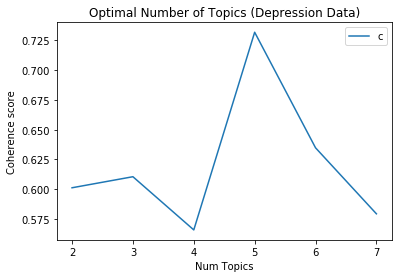

In [16]:
limit=8; start=2; 
x = range(start, limit)
plt.plot(x, coherence_values)
plt.title('Optimal Number of Topics (Depression Data)')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Once we have the weights and frequency of topic words, we are able to visualize the topics.

In [17]:
# visualize the topics
pyLDAvis.enable_notebook()
LDAvis_viz = pyLDAvis.gensim.prepare(best_model, corpus, dictionary)
LDAvis_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.348295 -0.222649       1        1  34.374612
2      0.214806 -0.049456       2        1  22.514816
4      0.009888  0.026653       3        1  17.170178
3     -0.140023  0.326758       4        1  13.385650
0      0.263624 -0.081306       5        1  12.554744, topic_info=                                Term         Freq        Total Category  \
term                                                                      
1197                    million_case  5793.000000  5793.000000  Default   
1196               disorder_pandemic  5808.000000  5808.000000  Default   
839                      really_help  7237.000000  7237.000000  Default   
1210                   research_find  6533.000000  6533.000000  Default   
1229                   wide_increase  4231.000000  4231.000000  Default   
1227                  lancet_october  4231.000000  4231.000000  Default   
1225                  document_world  4231.000000  4231.000000  Default   
684                             wide  2611.000000  2611.000000  Default   
1071                       published  2637.000000  2637.000000  Default   
271                         increase  2688.000000  2688.000000  Default   
1195                 study_published  3969.000000  3969.000000  Default   
1201                     acupuncture  4359.000000  4359.000000  Default   
1202                 beneficial_good  4355.000000  4355.000000  Default   
1207                   evidence_back  4355.000000  4355.000000  Default   
1209              performance_always  4355.000000  4355.000000  Default   
807                          million  3386.000000  3386.000000  Default   
1190                          lancet  3351.000000  3351.000000  Default   
1175                    live_podcast  1726.000000  1726.000000  Default   
1226    document_world_wide_increase  2118.000000  2118.000000  Default   
1228  study_published_lancet_october  2118.000000  2118.000000  Default   
1224                        document  1935.000000  1935.000000  Default   
1095                         reduces  2409.000000  2409.000000  Default   
935                       beneficial  2405.000000  2405.000000  Default   
939                             ssri  2745.000000  2745.000000  Default   
1176                     quote_radio  1218.000000  1218.000000  Default   
591                            major  1998.000000  1998.000000  Default   
262                             case  2105.000000  2105.000000  Default   
153                           really  2629.000000  2629.000000  Default   
805                          october  2012.000000  2012.000000  Default   
308                             good  2577.000000  2577.000000  Default   
...                              ...          ...          ...      ...   
1153                          second     7.936299    12.160987   Topic5   
994                           caring     7.802396    12.017578   Topic5   
1126                       nutrition    12.098467    18.801171   Topic5   
60                      22for22_ptsd    14.487850    22.727977   Topic5   
772                      mentalheath     7.217288    11.359248   Topic5   
1164                           empty     7.199107    11.348542   Topic5   
1073                    spirituality    14.738141    23.661636   Topic5   
12                            nature    15.049951    24.353345   Topic5   
807                          million  1281.815791  3386.793332   Topic5   
1070                    give_promise    19.223680    34.311631   Topic5   
1072                   selfhelp_book    19.207353    34.365810   Topic5   
1190                          lancet   685.809245  3351.509306   Topic5   
289                            study   498.967286  2261.646549   Topic5   
42                          disorder   294.974839  2511.665043   Topic5   
7                              world   200.741370  206

In [18]:
pyLDAvis.save_html(LDAvis_viz, 'Depression Visualization.html')

### We interpret the topics based on the keywords.

In [20]:
print('1: Treatment/Tips')
print('2: Studies/Publications')
print('3: Online/Mindfulness')
print('4: Irrelevant')
print('5: Stats/Pandemic news')

1: Treatment/Tips
2: Studies/Publications
3: Online/Mindfulness
4: Irrelevant
5: Stats/Pandemic news
